In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import os

from utils.model.models import Classifier
from utils.model.train import train_classifier
from utils.config import config as cfg

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Current device:", device)

default_dirs = cfg.get_default_dirs()

Current device: cuda:0


In [5]:
# Custom dataset with our model parameters
class ModelParamsDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path, angle_change: int = 90):
        self.dataset_path = dataset_path
        self.dataset = pd.read_csv(dataset_path)
        self.angle_change = angle_change

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        weights = torch.tensor(self.dataset.iloc[idx, 1:-1].astype('float32').values)
        angle = torch.tensor(self.dataset.iloc[idx, -1]/self.angle_change, dtype=torch.int64)

        return weights, angle

In [106]:
dataset_name = "two_angles.csv"
dataset_path = os.path.join(default_dirs["DATASETS_DIR"], dataset_name)

# Create a dataset
dataset = ModelParamsDataset(dataset_path)

torch.manual_seed(42)

# Split into train, validation and test sets
dataset_train, dataset_valid, dataset_test = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1])
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=32, shuffle=True)
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=32, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test)

print("Train sample:", len(dataset_train))
print("Validation sample:", len(dataset_valid))
print("Test sample:", len(dataset_test))

Train sample: 3200
Validation sample: 400
Test sample: 400


  0%|          | 0/10 [00:00<?, ?it/s]

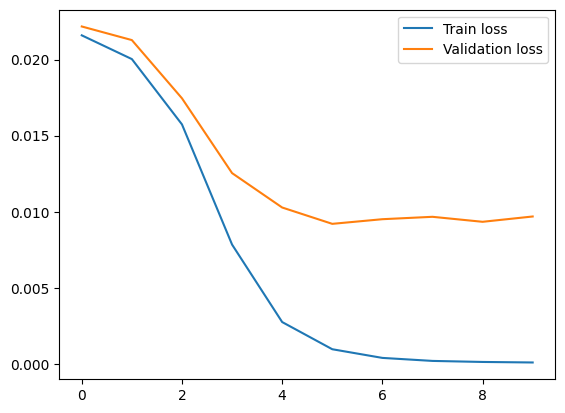

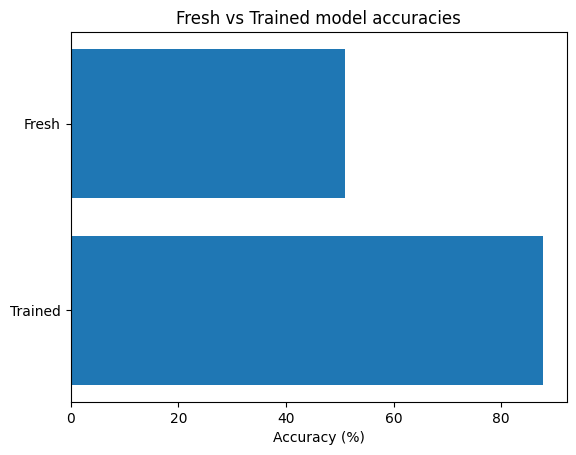

In [121]:
# Load training config
config_name = "0_train_angle_classifier_2.yaml"
config = cfg.load_config(config_name, True)

# Hyperparameters
hyperparameters = config["HYPERPARAMETERS"]
epochs = hyperparameters["EPOCHS"]
learning_rate = hyperparameters["LEARNING_RATE"]
seed = hyperparameters["SEED"]

model_config = config["MODEL"]
input_dim = model_config["INPUT_DIM"]
hidden_dims = model_config["HIDDEN_DIMS"]
output_dim = model_config["OUTPUT_DIM"]
dropout = model_config["DROPOUT"]

# TRAINING
torch.manual_seed(seed)

model = Classifier(input_dim, hidden_dims, output_dim, dropout)
model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
valid_losses = []

# Training
for epoch in tqdm(range(epochs)):
    total_loss = 0
    model.train()
    for X, y in dataloader_train:
        X = X.to(device)
        y = y.to(device)
        y_pred = model(X.float())
        y = torch.nn.functional.one_hot(y, output_dim).float()
        loss = criterion(y_pred, y)
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    total_loss /= len(dataloader_train.dataset)
    train_losses.append(total_loss)

    total_loss = 0
    model.eval()
    for X, y in dataloader_valid:
        X = X.to(device)
        y = y.to(device)
        y_pred = model(X.float())
        y = torch.nn.functional.one_hot(y, num_classes=output_dim).float()
        loss = criterion(y_pred, y)
        total_loss += loss.item()
    
    total_loss /= len(dataloader_valid.dataset)
    valid_losses.append(total_loss)

plt.plot(train_losses, label="Train loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()
plt.show()

model_fresh = Classifier(input_dim, hidden_dims, output_dim)
model_fresh.to(device)

total_correct = 0
for X, y in dataloader_test:
    X = X.to(device)
    y = y.to(device)
    y_pred = model_fresh(X.float())
    # Accuracy
    y_pred = torch.argmax(y_pred, dim=1)
    correct = (y_pred == y).sum()
    total_correct += correct

accuracy_fresh = total_correct / len(dataloader_test.dataset) * 100
total_correct = 0
for X, y in dataloader_test:
    X = X.to(device)
    y = y.to(device)
    y_pred = model(X.float())
    # Accuracy
    y_pred = torch.argmax(y_pred, dim=1)
    correct = (y_pred == y).sum()
    total_correct += correct

accuracy_trained = total_correct / len(dataloader_test.dataset) * 100

plt.title("Fresh vs Trained model accuracies")
plt.barh(["Trained", "Fresh"], [accuracy_trained.cpu().detach().numpy(), accuracy_fresh.cpu().detach().numpy()])
plt.xlabel("Accuracy (%)")
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

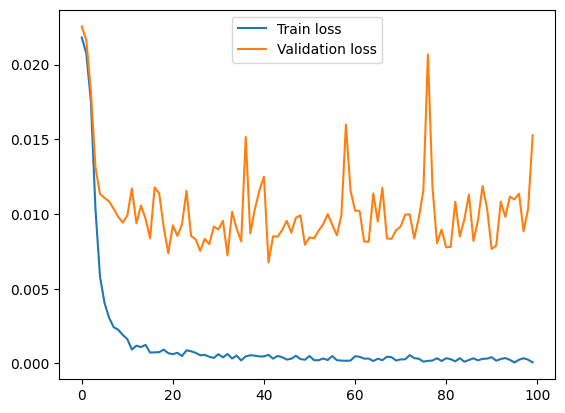

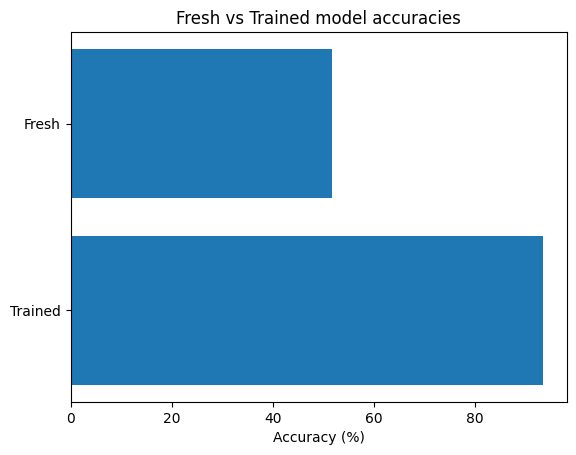

In [127]:
# Load training config
config_name = "1_train_angle_classifier_2.yaml"
config = cfg.load_config(config_name, True)

# Hyperparameters
hyperparameters = config["HYPERPARAMETERS"]
epochs = hyperparameters["EPOCHS"]
learning_rate = hyperparameters["LEARNING_RATE"]
seed = hyperparameters["SEED"]

model_config = config["MODEL"]
input_dim = model_config["INPUT_DIM"]
hidden_dims = model_config["HIDDEN_DIMS"]
output_dim = model_config["OUTPUT_DIM"]
dropout = model_config["DROPOUT"]

# TRAINING
torch.manual_seed(seed)

model = Classifier(input_dim, hidden_dims, output_dim, dropout)
model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
valid_losses = []

# Training
for epoch in tqdm(range(epochs)):
    total_loss = 0
    model.train()
    for X, y in dataloader_train:
        X = X.to(device)
        y = y.to(device)
        y_pred = model(X.float())
        y = torch.nn.functional.one_hot(y, output_dim).float()
        loss = criterion(y_pred, y)
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    total_loss /= len(dataloader_train.dataset)
    train_losses.append(total_loss)

    total_loss = 0
    model.eval()
    for X, y in dataloader_valid:
        X = X.to(device)
        y = y.to(device)
        y_pred = model(X.float())
        y = torch.nn.functional.one_hot(y, num_classes=output_dim).float()
        loss = criterion(y_pred, y)
        total_loss += loss.item()
    
    total_loss /= len(dataloader_valid.dataset)
    valid_losses.append(total_loss)

plt.plot(train_losses, label="Train loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()
plt.show()

model_fresh = Classifier(input_dim, hidden_dims, output_dim)
model_fresh.to(device)

total_correct = 0
for X, y in dataloader_test:
    X = X.to(device)
    y = y.to(device)
    y_pred = model_fresh(X.float())
    # Accuracy
    y_pred = torch.argmax(y_pred, dim=1)
    correct = (y_pred == y).sum()
    total_correct += correct

accuracy_fresh = total_correct / len(dataloader_test.dataset) * 100
total_correct = 0
for X, y in dataloader_test:
    X = X.to(device)
    y = y.to(device)
    y_pred = model(X.float())
    # Accuracy
    y_pred = torch.argmax(y_pred, dim=1)
    correct = (y_pred == y).sum()
    total_correct += correct

accuracy_trained = total_correct / len(dataloader_test.dataset) * 100

plt.title("Fresh vs Trained model accuracies")
plt.barh(["Trained", "Fresh"], [accuracy_trained.cpu().detach().numpy(), accuracy_fresh.cpu().detach().numpy()])
plt.xlabel("Accuracy (%)")
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

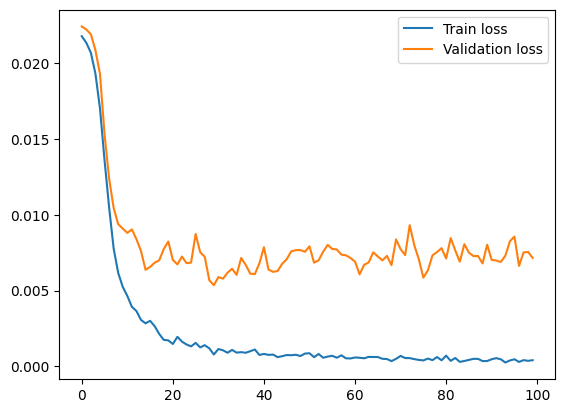

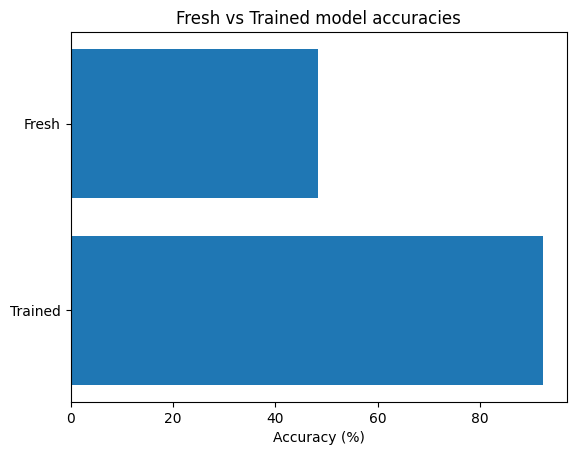

In [130]:
# Load training config
config_name = "2_train_angle_classifier_2.yaml"
config = cfg.load_config(config_name, True)

# Hyperparameters
hyperparameters = config["HYPERPARAMETERS"]
epochs = hyperparameters["EPOCHS"]
learning_rate = hyperparameters["LEARNING_RATE"]
seed = hyperparameters["SEED"]

model_config = config["MODEL"]
input_dim = model_config["INPUT_DIM"]
hidden_dims = model_config["HIDDEN_DIMS"]
output_dim = model_config["OUTPUT_DIM"]
dropout = model_config["DROPOUT"]

# TRAINING
torch.manual_seed(seed)

model = Classifier(input_dim, hidden_dims, output_dim, dropout)
model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
valid_losses = []

# Training
for epoch in tqdm(range(epochs)):
    total_loss = 0
    model.train()
    for X, y in dataloader_train:
        X = X.to(device)
        y = y.to(device)
        y_pred = model(X.float())
        y = torch.nn.functional.one_hot(y, output_dim).float()
        loss = criterion(y_pred, y)
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    total_loss /= len(dataloader_train.dataset)
    train_losses.append(total_loss)

    total_loss = 0
    model.eval()
    for X, y in dataloader_valid:
        X = X.to(device)
        y = y.to(device)
        y_pred = model(X.float())
        y = torch.nn.functional.one_hot(y, num_classes=output_dim).float()
        loss = criterion(y_pred, y)
        total_loss += loss.item()
    
    total_loss /= len(dataloader_valid.dataset)
    valid_losses.append(total_loss)

plt.plot(train_losses, label="Train loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()
plt.show()

model_fresh = Classifier(input_dim, hidden_dims, output_dim)
model_fresh.to(device)

total_correct = 0
for X, y in dataloader_test:
    X = X.to(device)
    y = y.to(device)
    y_pred = model_fresh(X.float())
    # Accuracy
    y_pred = torch.argmax(y_pred, dim=1)
    correct = (y_pred == y).sum()
    total_correct += correct

accuracy_fresh = total_correct / len(dataloader_test.dataset) * 100
total_correct = 0
for X, y in dataloader_test:
    X = X.to(device)
    y = y.to(device)
    y_pred = model(X.float())
    # Accuracy
    y_pred = torch.argmax(y_pred, dim=1)
    correct = (y_pred == y).sum()
    total_correct += correct

accuracy_trained = total_correct / len(dataloader_test.dataset) * 100

plt.title("Fresh vs Trained model accuracies")
plt.barh(["Trained", "Fresh"], [accuracy_trained.cpu().detach().numpy(), accuracy_fresh.cpu().detach().numpy()])
plt.xlabel("Accuracy (%)")
plt.show()

In [6]:
dataset_name = "four_angles.csv"
dataset_path = os.path.join(default_dirs["DATASETS_DIR"], dataset_name)

# Create a dataset
dataset = ModelParamsDataset(dataset_path)

torch.manual_seed(42)

# Split into train, validation and test sets
dataset_train, dataset_valid, dataset_test = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1])
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=32, shuffle=True)
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=32, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test)

print("Train sample:", len(dataset_train))
print("Validation sample:", len(dataset_valid))
print("Test sample:", len(dataset_test))

Train sample: 6400
Validation sample: 800
Test sample: 800


  0%|          | 0/300 [00:00<?, ?it/s]

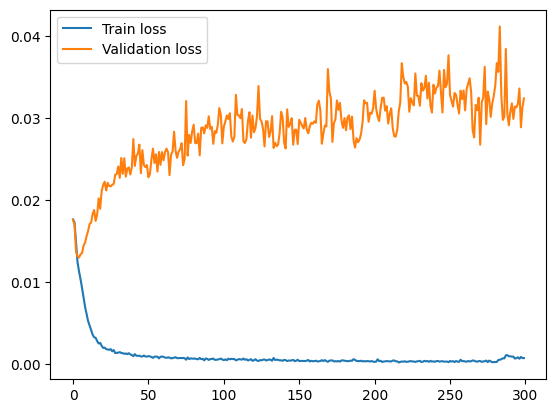

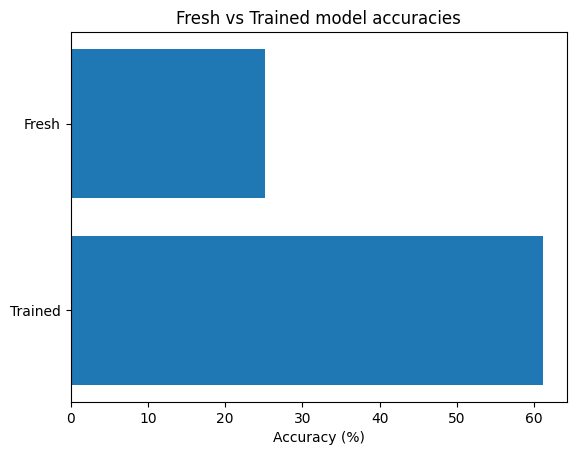

In [14]:
# Load training config
config_name = "0_train_angle_classifier_4.yaml"
config = cfg.load_config(config_name, True)

# Hyperparameters
hyperparameters = config["HYPERPARAMETERS"]
epochs = hyperparameters["EPOCHS"]
learning_rate = hyperparameters["LEARNING_RATE"]
seed = hyperparameters["SEED"]

model_config = config["MODEL"]
input_dim = model_config["INPUT_DIM"]
hidden_dims = model_config["HIDDEN_DIMS"]
output_dim = model_config["OUTPUT_DIM"]
dropout = model_config["DROPOUT"]

# TRAINING
torch.manual_seed(seed)

model = Classifier(input_dim, hidden_dims, output_dim, dropout)
model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
valid_losses = []

# Training
for epoch in tqdm(range(epochs)):
    total_loss = 0
    model.train()
    for X, y in dataloader_train:
        X = X.to(device)
        y = y.to(device)
        y_pred = model(X.float())
        y = torch.nn.functional.one_hot(y, output_dim).float()
        loss = criterion(y_pred, y)
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    total_loss /= len(dataloader_train.dataset)
    train_losses.append(total_loss)

    total_loss = 0
    model.eval()
    for X, y in dataloader_valid:
        X = X.to(device)
        y = y.to(device)
        y_pred = model(X.float())
        y = torch.nn.functional.one_hot(y, num_classes=output_dim).float()
        loss = criterion(y_pred, y)
        total_loss += loss.item()
    
    total_loss /= len(dataloader_valid.dataset)
    valid_losses.append(total_loss)

plt.plot(train_losses, label="Train loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()
plt.show()

model_fresh = Classifier(input_dim, hidden_dims, output_dim)
model_fresh.to(device)

total_correct = 0
for X, y in dataloader_test:
    X = X.to(device)
    y = y.to(device)
    y_pred = model_fresh(X.float())
    # Accuracy
    y_pred = torch.argmax(y_pred, dim=1)
    correct = (y_pred == y).sum()
    total_correct += correct

accuracy_fresh = total_correct / len(dataloader_test.dataset) * 100
total_correct = 0
for X, y in dataloader_test:
    X = X.to(device)
    y = y.to(device)
    y_pred = model(X.float())
    # Accuracy
    y_pred = torch.argmax(y_pred, dim=1)
    correct = (y_pred == y).sum()
    total_correct += correct

accuracy_trained = total_correct / len(dataloader_test.dataset) * 100

plt.title("Fresh vs Trained model accuracies")
plt.barh(["Trained", "Fresh"], [accuracy_trained.cpu().detach().numpy(), accuracy_fresh.cpu().detach().numpy()])
plt.xlabel("Accuracy (%)")
plt.show()